#Objective:
A machine learning project that detects the presence of diseases in plants using image data. The model analyzes leaf images to classify whether a plant is healthy or affected by a specific disease, helping support early detection and agricultural health monitoring.

#Column Details:
* **temperature:** Measured in degrees Celsius
* **humidity**: Measured as percentage
* **rainfall**: Measured in millimeters
* **soil_pH**: Acidity/alkalinity measurement
* **disease_present**: Binary label (0 = healthy, 1 = diseased)


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score
)

import xgboost
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

from sklearn.neural_network import MLPClassifier

In [2]:
# Loading the dataset
data = pd.read_csv("/content/plant_disease_dataset.csv")
data.head()

,temperature,humidity,rainfall,soil_pH,disease_present
0,27.483571,33.215053,0.572758,4.975875,1
1,24.308678,36.945005,42.522346,8.165266,0
2,28.238443,34.026189,16.095303,6.316734,1
3,32.615149,41.104180,20.311015,6.164949,0
4,23.829233,51.971785,11.851323,8.482468,0


In [3]:
data.tail()

,temperature,humidity,rainfall,soil_pH,disease_present
9995,31.505510,81.939137,22.406822,5.862952,1
9996,15.008275,86.886833,10.503881,4.070539,0
9997,21.473416,81.891770,13.426869,7.101583,0
9998,27.478828,88.567649,9.719659,7.732620,0
9999,28.221942,71.900401,4.886391,4.383536,0


In [4]:
data.shape

(10000, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      10000 non-null  float64
 1   humidity         10000 non-null  float64
 2   rainfall         10000 non-null  float64
 3   soil_pH          10000 non-null  float64
 4   disease_present  10000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,10000.0,25.612191,5.813841,5.387999,21.815610,25.293238,28.916048,56.686495
humidity,10000.0,62.119300,22.679977,6.244209,40.772925,72.211752,81.032999,102.395421
rainfall,10000.0,9.807522,9.852130,0.000055,2.812822,6.864898,13.442871,84.654161
soil_pH,10000.0,6.245855,1.302465,4.000075,5.122970,6.232188,7.386377,8.499875
disease_present,10000.0,0.241000,0.427712,0.000000,0.000000,0.000000,0.000000,1.000000


In [7]:
data.isnull().sum()

,0
temperature,0
humidity,0
rainfall,0
soil_pH,0
disease_present,0


In [8]:
print(data.duplicated().sum())

0


In [9]:
data['disease_present'].map({1:"Yes", 0:"No"}).value_counts()

,count
disease_present,
No,7590
Yes,2410


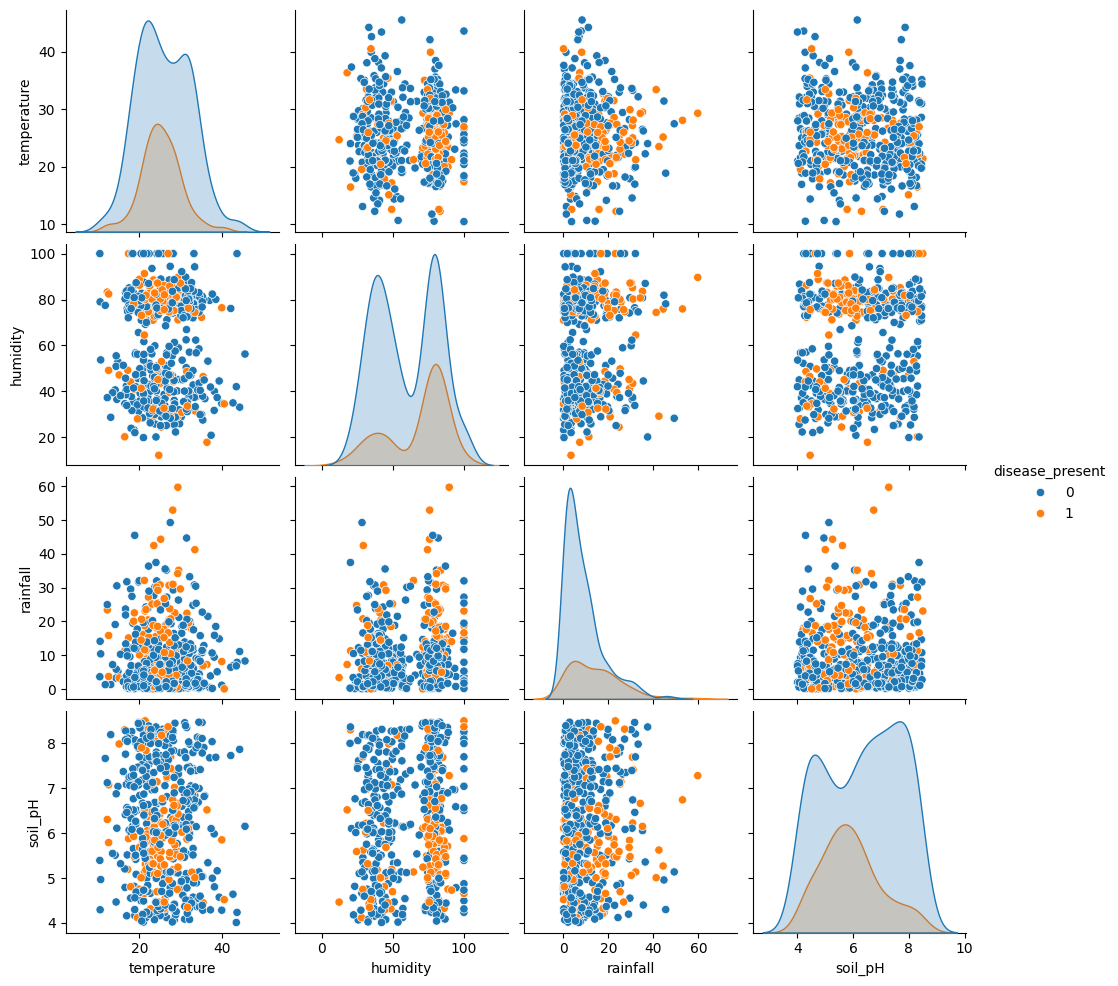

In [10]:
# Pirplot
sns.pairplot(data.sample(500), hue='disease_present')
plt.show()

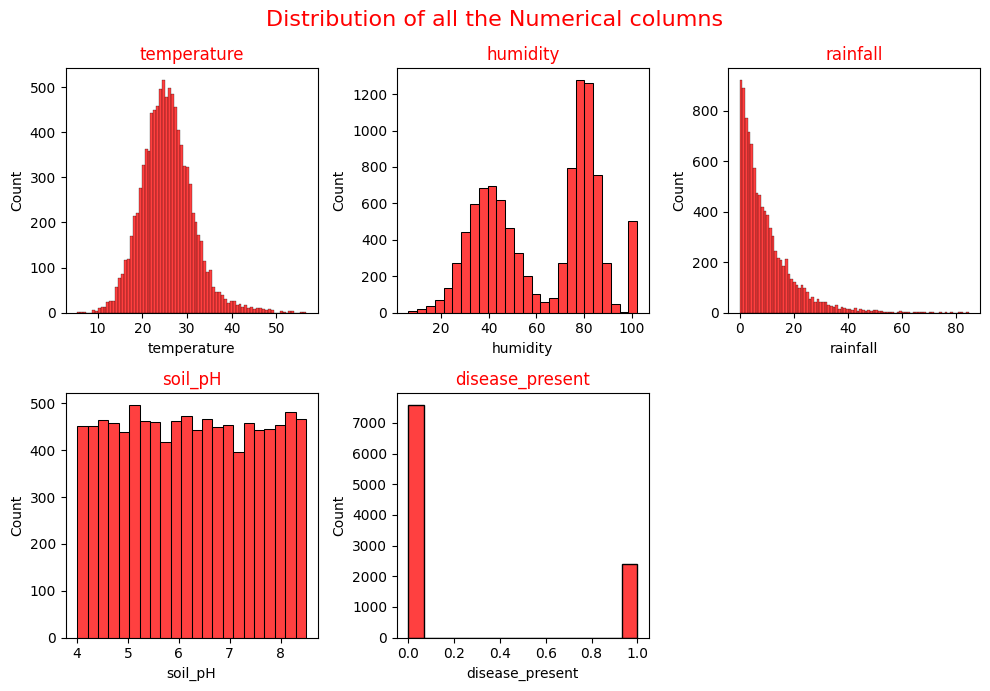

In [11]:
# Let's check the distribution of all the numerical columns
plt.figure(figsize=(10, 7))
plt.suptitle("Distribution of all the Numerical columns", size=16, color="red")
index = 0
for col in data.columns:
    index += 1
    plt.subplot(2, 3, index)
    plt.title(f"{col}", color="red")
    sns.histplot(data[col], color="red")
    plt.tight_layout()
plt.show()

* Looks like most of the columns are normally distributed except for "rainfall".

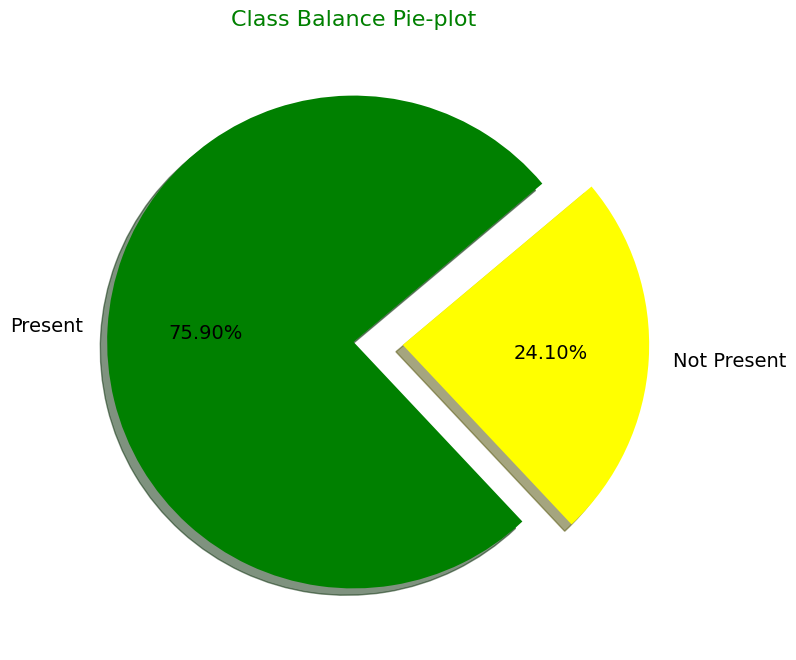

In [12]:
# Checking for class imbalance
plt.figure(figsize=(8, 8))
plt.pie(data['disease_present'].value_counts(), autopct="%.2f%%", colors=['green', 'yellow'],
        labels=['Present', 'Not Present'], explode=[0, 0.2], shadow=True, textprops={"fontsize":14},
        startangle=40)
plt.title("Class Balance Pie-plot", color='green', size=16)
plt.show()

* With this pie plot we can infer that there is a presence of class imbalance in the dataset, still we will work on it only if our classifier models are not able to classify the minority class correctly.

In [13]:
# Let's separate features and target variable
x = data.drop('disease_present', axis=1)
y = data['disease_present']
x.shape, y.shape

((10000, 4), (10000,))

In [23]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x, y)
y_res.value_counts()

,count
disease_present,
1,7590
0,7590


In [25]:
# Let's separate the data for training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((12144, 4), (3036, 4), (12144,), (3036,))

In [29]:
# Let's scale our dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s = scaler.transform(x_test)

In [30]:
# Let's create a method to evaluate our models
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score
)

# Global dictionary to store results
model_results = {}

def eval_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)

    # --- Print classification report ---
    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    # --- Confusion matrix ---
    print("\n🔢 Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    # --- Compute metrics ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    # --- Build a unique model key ---
    base_name = model.__class__.__name__
    i = 1
    key = base_name
    while key in model_results:
        i += 1
        key = f"{base_name}_{i}"

    # --- Store metrics in the dictionary ---
    model_results[key] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec
    }

    print(f"\n✅ Stored results under key: '{key}'")

In [31]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

lr = LogisticRegression()#fit_intercept=False, C=10)
lr.fit(x_train_s, y_train)

LogisticRegression()


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      1518
           1       0.66      0.68      0.67      1518

    accuracy                           0.66      3036
   macro avg       0.66      0.66      0.66      3036
weighted avg       0.66      0.66      0.66      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'LogisticRegression'


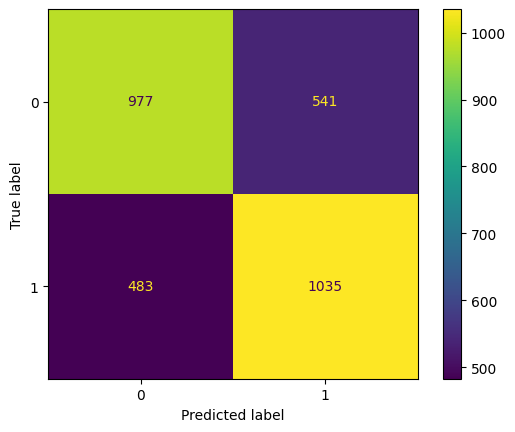

In [32]:
from sklearn.metrics import accuracy_score, classification_report

# print(classification_report(y_test, lr.predict(x_test_s)))
eval_metrics(lr, x_test_s, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      1518
           1       0.66      0.69      0.67      1518

    accuracy                           0.67      3036
   macro avg       0.67      0.67      0.67      3036
weighted avg       0.67      0.67      0.67      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'LogisticRegressionCV'


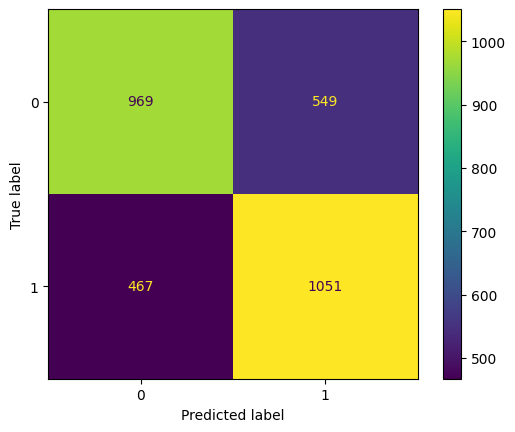

In [33]:
lrcv = LogisticRegressionCV(cv=4)
lrcv.fit(x_train_s, y_train)

# print(classification_report(y_test, lrcv.predict(x_test_s)))
eval_metrics(lrcv, x_test_s, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1518
           1       0.78      0.81      0.80      1518

    accuracy                           0.79      3036
   macro avg       0.79      0.79      0.79      3036
weighted avg       0.79      0.79      0.79      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'DecisionTreeClassifier'


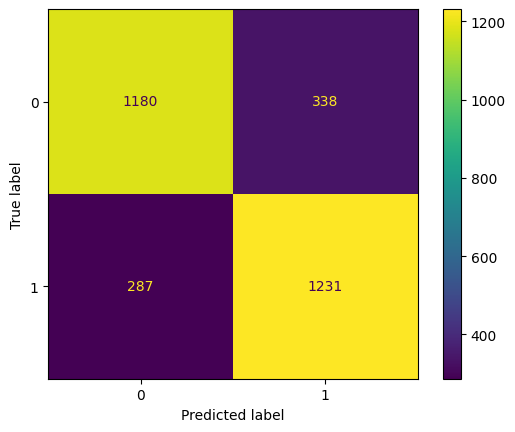

In [34]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
# print(classification_report(y_test, dtc.predict(x_test)))
eval_metrics(dtc, x_test, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1518
           1       0.88      0.82      0.85      1518

    accuracy                           0.86      3036
   macro avg       0.86      0.86      0.85      3036
weighted avg       0.86      0.86      0.85      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'RandomForestClassifier'


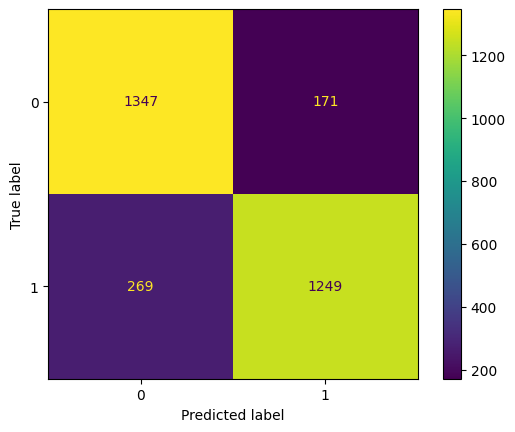

In [35]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
# print(classification_report(y_test, rfc.predict(x_test)))
eval_metrics(rfc, x_test, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1518
           1       0.82      0.75      0.78      1518

    accuracy                           0.79      3036
   macro avg       0.79      0.79      0.79      3036
weighted avg       0.79      0.79      0.79      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'SVC'


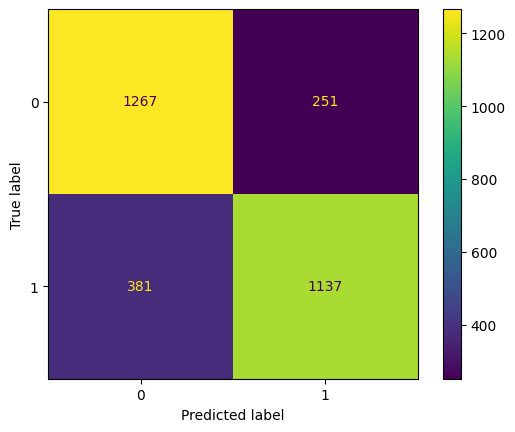

In [36]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf')
svc.fit(x_train_s, y_train)
# print(classification_report(y_test, svc.predict(x_test_s)))
eval_metrics(svc, x_test_s, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1518
           1       0.83      0.77      0.80      1518

    accuracy                           0.80      3036
   macro avg       0.81      0.80      0.80      3036
weighted avg       0.81      0.80      0.80      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'KNeighborsClassifier'


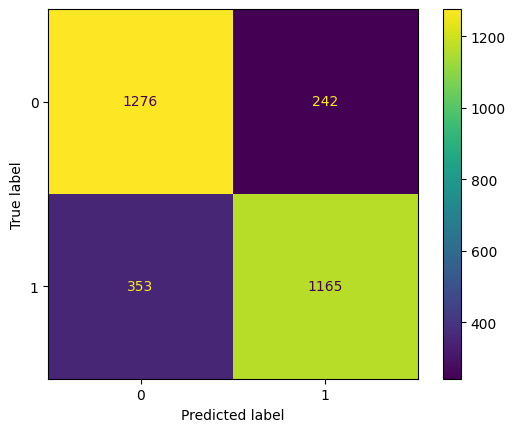

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(n_neighbors=20)
knc.fit(x_train_s, y_train)
# print(classification_report(y_test, knc.predict(x_test_s)))
eval_metrics(knc, x_test_s, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1518
           1       0.85      0.79      0.82      1518

    accuracy                           0.83      3036
   macro avg       0.83      0.83      0.83      3036
weighted avg       0.83      0.83      0.83      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'XGBClassifier'


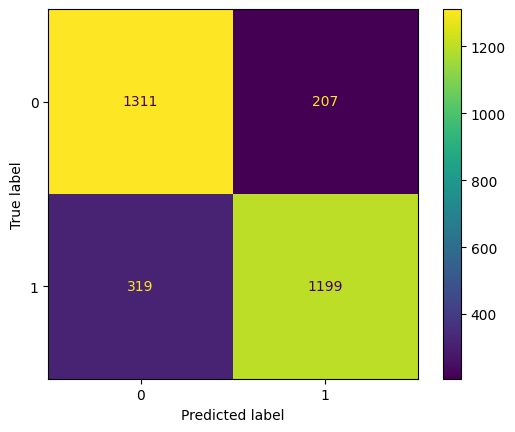

In [38]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train)
eval_metrics(xgb, x_test, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1518
           1       0.87      0.85      0.86      1518

    accuracy                           0.86      3036
   macro avg       0.86      0.86      0.86      3036
weighted avg       0.86      0.86      0.86      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'ExtraTreesClassifier'


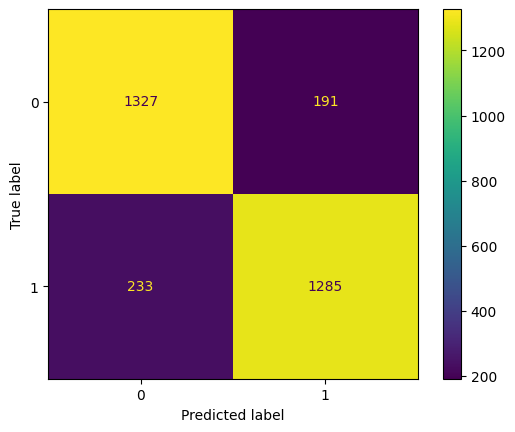

In [39]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(x_train, y_train)
eval_metrics(etc, x_test, y_test)

[LightGBM] [Info] Number of positive: 6072, number of negative: 6072
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 12144, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1518
           1       0.89      0.75      0.81      1518

    accuracy                           0.83      3036
   macro avg       0.83      0.83      0.83      3036
weighted avg       0.83      0.83      0.83      3036


🔢 Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



✅ Stored results under key: 'LGBMClassifier'


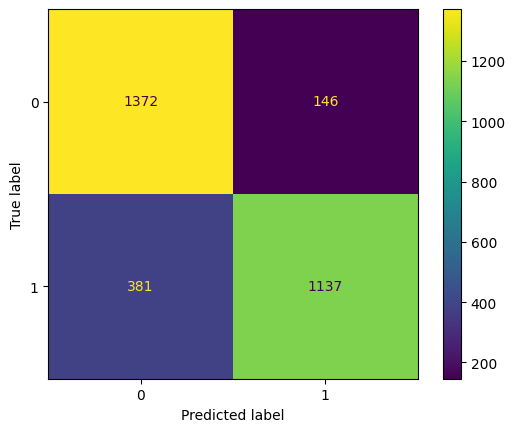

In [40]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier()
lgbm.fit(x_train_s, y_train)

eval_metrics(lgbm, x_test_s, y_test)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1518
           1       0.87      0.73      0.79      1518

    accuracy                           0.81      3036
   macro avg       0.82      0.81      0.81      3036
weighted avg       0.82      0.81      0.81      3036


🔢 Confusion Matrix:

✅ Stored results under key: 'MLPClassifier'


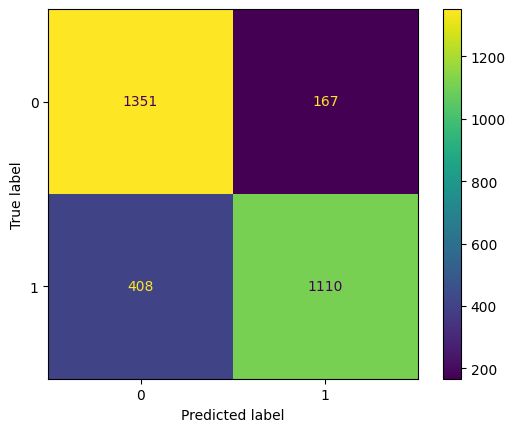

In [41]:
# NN Using Sklearn
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 16),  # Two hidden layers: 64 and 16 units
    activation='relu',            # ReLU activation for hidden layers
    solver='adam',                # Optimizer
    alpha=0.001,                  # L2 regularization (kind of like dropout)
    max_iter=500,                 # Max training iterations
    random_state=42
)
mlp.fit(x_train_s, y_train)
eval_metrics(mlp, x_test_s, y_test)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers

model = Sequential([
    Dense(4, input_shape=(4, )),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Model Training
model.fit(x_train_s, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5762 - loss: 0.6786 - val_accuracy: 0.6879 - val_loss: 0.6126
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6797 - loss: 0.6239 - val_accuracy: 0.7077 - val_loss: 0.5892
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7047 - loss: 0.5889 - val_accuracy: 0.7308 - val_loss: 0.5707
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7146 - loss: 0.5912 - val_accuracy: 0.7353 - val_loss: 0.5595
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7268 - loss: 0.5717 - val_accuracy: 0.7349 - val_loss: 0.5558
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7244 - loss: 0.5653 - val_accuracy: 0.7332 - val_loss: 0.5544
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7331 - loss: 0.5584 - val_accuracy: 0.7324 - val_loss: 0.5507
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.5544 - val_accuracy: 0.

In [44]:
# eval_metrics(model, x_test_s, y_test)
y_pred = model.predict(x_test_s)
y_pred_pd = pd.DataFrame(y_pred, columns=['predictions'])
y_pred_pd

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,predictions
0,0.307817
1,0.915230
2,0.349858
3,0.310793
4,0.798661
...,...
3031,0.265092
3032,0.949661
3033,0.946964
3034,0.754881


In [45]:
# y_pred.all(lambda x : 1 if x>=0.5 else 0)
predictions = y_pred_pd['predictions'].apply(lambda x: 1 if x>=0.5 else 0)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.80      1518
           1       0.84      0.69      0.76      1518

    accuracy                           0.78      3036
   macro avg       0.79      0.78      0.78      3036
weighted avg       0.79      0.78      0.78      3036


🔢 Confusion Matrix:


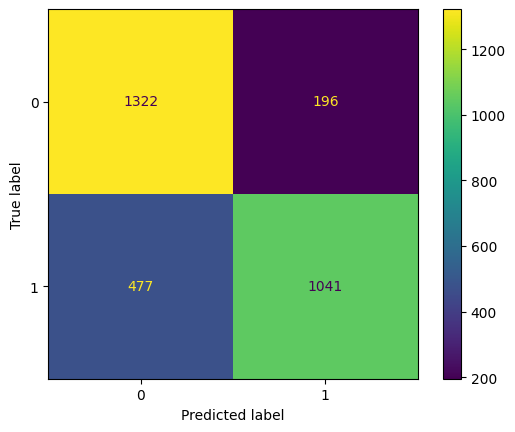

In [46]:
# --- Print classification report ---
print("\n📊 Classification Report:")
print(classification_report(y_test, predictions))

# --- Confusion matrix ---
print("\n🔢 Confusion Matrix:")
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=model.classes_)
disp.plot()

In [47]:
acc = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions)
rec = recall_score(y_test, predictions)
print(acc, prec, rec)

0.77832674571805 0.841552142279709 0.6857707509881423


In [48]:
metric_df = pd.DataFrame(model_results)
metric_df

,LogisticRegression,LogisticRegressionCV,DecisionTreeClassifier,RandomForestClassifier,SVC,KNeighborsClassifier,XGBClassifier,ExtraTreesClassifier,LGBMClassifier,MLPClassifier
accuracy,0.662714,0.665349,0.794137,0.855072,0.791831,0.804018,0.826746,0.860343,0.826416,0.810606
precision,0.656726,0.656875,0.784576,0.879577,0.819164,0.828003,0.852774,0.870596,0.886204,0.869225
recall,0.681818,0.692358,0.810935,0.822793,0.749012,0.767457,0.789855,0.846509,0.749012,0.731225


In [49]:
# updating the above defined dictionary for tensorflow model
metric_df['tf_model'] = [acc, prec, rec]
metric_df = pd.DataFrame(metric_df).T
metric_df

,accuracy,precision,recall
LogisticRegression,0.662714,0.656726,0.681818
LogisticRegressionCV,0.665349,0.656875,0.692358
DecisionTreeClassifier,0.794137,0.784576,0.810935
RandomForestClassifier,0.855072,0.879577,0.822793
SVC,0.791831,0.819164,0.749012
KNeighborsClassifier,0.804018,0.828003,0.767457
XGBClassifier,0.826746,0.852774,0.789855
ExtraTreesClassifier,0.860343,0.870596,0.846509
LGBMClassifier,0.826416,0.886204,0.749012
MLPClassifier,0.810606,0.869225,0.731225


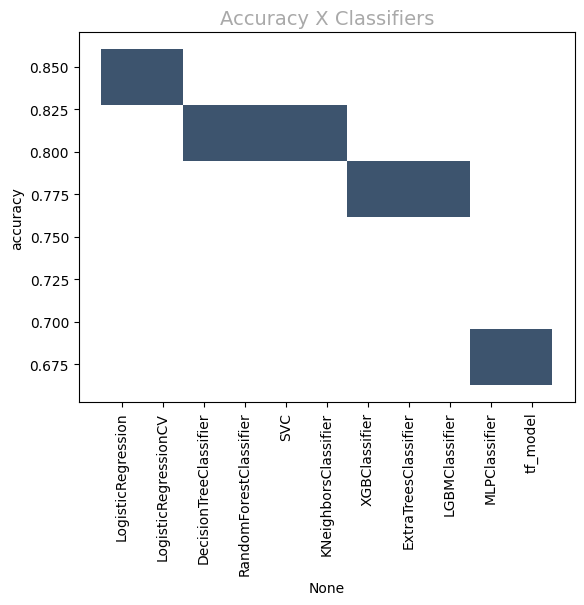

In [50]:
# Histplot based on Accuracy and Classifiers
sns.histplot(x=metric_df.index, y=metric_df.accuracy.sort_values(ascending=False))
plt.title("Accuracy X Classifiers", size=14, color='darkgrey')
plt.xticks(rotation=90)
plt.show()

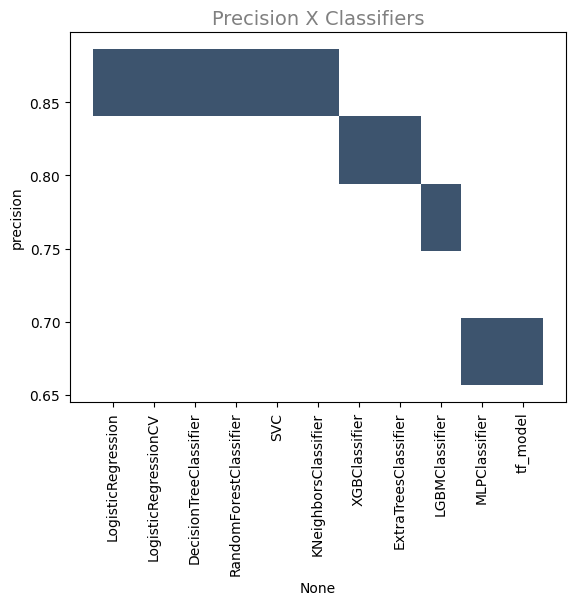

In [51]:
# Histplot based on Precision and Classifiers
sns.histplot(x=metric_df.index, y=metric_df.precision.sort_values(ascending=False))
plt.title("Precision X Classifiers", size=14, color='grey')
plt.xticks(rotation=90)
plt.show()

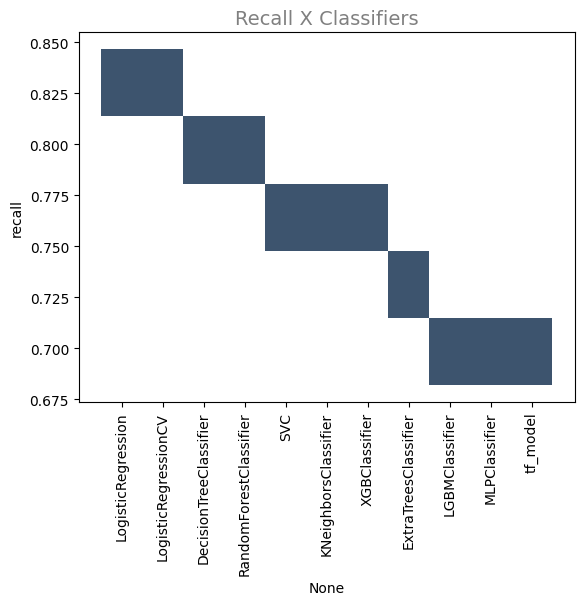

In [52]:
# Histplot based on Recall and Classifiers
sns.histplot(x=metric_df.index, y=metric_df.recall.sort_values(ascending=False))
plt.title("Recall X Classifiers", size=14, color='grey')
plt.xticks(rotation=90)
plt.show()

In [53]:
print("Best Models Based on Accuracy are: \n", metric_df[metric_df['accuracy'] == metric_df['accuracy'].max()])

Best Models Based on Accuracy are: 
                       accuracy  precision    recall
ExtraTreesClassifier  0.860343   0.870596  0.846509


In [54]:
print("Best Models Based on Precision is: \n", metric_df[metric_df['precision'] == metric_df['precision'].max()])

Best Models Based on Precision is: 
                 accuracy  precision    recall
LGBMClassifier  0.826416   0.886204  0.749012


In [55]:
print("Best Models Based on Recall are: \n", metric_df[metric_df['recall'] == metric_df['recall'].max()])

Best Models Based on Recall are: 
                       accuracy  precision    recall
ExtraTreesClassifier  0.860343   0.870596  0.846509


### Conclusion:
With this note we come to a subtle conclusion that LGBM is preforming the best and we have made use of almost all of the basic and advance models to experiment with various values.
Since there was actually quite less number of features, this is not a bad result.

### Future imporvements:
* Include more advanced and complicated feature engineering steps.
* Additional use of imbalanced class.
* Further we can deploy the model using Dockers and a stable architecture.

### EDIT 1 :
* Balanced class using SMOTE
* Re-ran all the codes
* We found improvements on predicting individual classes
* Short-coming - Since we have simulated data it might not be upto production level.

***Any future updates will be summarized above.***

Thank you for going through this till the end, feel free to get in touch if you have any questions... :)